# Validation of dynamic solver

The solution methods are implemented in uvlm2d_dyn.solver, while tests are recorded in test_dyn.py.


In [1]:
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import uvlm2d_dyn as uvlm
import pp_uvlm2d as pp
import analytical as an
import set_dyn, set_gust

## Steady state:
This case looks at the solution at a steady angle of attack. The wake is used in the time-stepping procedure, but should have no impact on the solution accuracy. A very short wake is, therefore, used. Hall's correction (1994) should also have no impact on the results.

Done in 0.0 sec!
Done in 0.1 sec!
Done in 0.5 sec!


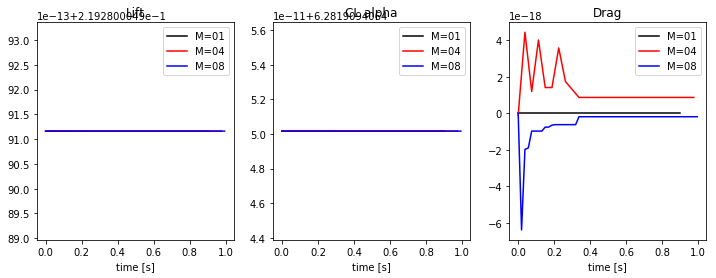

In [2]:
### random geometry
c=3.
b=0.5*c
uinf=20.0
T=1.0
WakeFact=2
TimeList=[]
THCFList=[]
MList=[1,4,8]
for mm in range(len(MList)):
    M=MList[mm]
    S=uvlm.solver(T=T,M=M,Mw=M*WakeFact,b=b,Uinf=np.array([uinf,0.]),
                  alpha=2.*np.pi/180.,rho=1.225)
    S.build_flat_plate()
    S.eps_Hall=1.0 # no correction
    S.solve_dyn_Gamma2d()
    TimeList.append(S.time)
    THCFList.append(S.THFaero/S.qinf/S.chord)
clist=['k','r','b','0.6',]
fig = plt.figure('Aerodynamic forces',(12,4))
ax=fig.add_subplot(131)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Lift')
ax.legend()
ax=fig.add_subplot(132)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1]/S.alpha,clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('CL alpha')
ax.legend()
ax=fig.add_subplot(133)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,0],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Drag')
ax.legend()	
plt.show()

As expected:
- Hall's correction is not required. The correction, in fact, accumulates "net" vorticity at the last vortex. The nex vorticity in the wake is, however, null (despite the vortex rings carrying a non-zero vorticity, which is the accumulated vorticity at the aerofoil).
- Quantities remain constant, and the $CL_\alpha$ is always equal to $2\pi$. No induced drag, as expected.
- Interestingly, we get no jump in the aerodynamic force at the beginning of the simulation - which is, instead, a feature of 3D UVLM SHARPy implementation.

Nothing changes when Hall's correction is introduced:

Done in 0.0 sec!
Done in 0.1 sec!
Done in 0.5 sec!


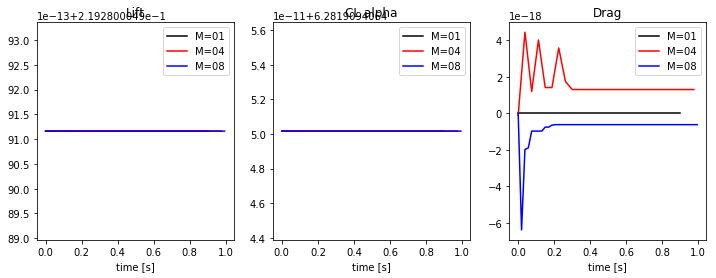

In [3]:
TimeList=[]
THCFList=[]
for mm in range(len(MList)):
    M=MList[mm]
    S=uvlm.solver(T=T,M=M,Mw=M*WakeFact,b=b,Uinf=np.array([uinf,0.]),
                  alpha=2.*np.pi/180.,rho=1.225)
    S.build_flat_plate()
    S.eps_Hall=0.003
    S.solve_dyn_Gamma2d()
    TimeList.append(S.time)
    THCFList.append(S.THFaero/S.qinf/S.chord)

clist=['k','r','b','0.6',]
fig = plt.figure('Aerodynamic forces',(12,4))
ax=fig.add_subplot(131)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Lift')
ax.legend()
ax=fig.add_subplot(132)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,1]/S.alpha,clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('CL alpha')
ax.legend()
ax=fig.add_subplot(133)
for mm in range(len(MList)):
    ax.plot(TimeList[mm],THCFList[mm][:,0],clist[mm],label=r'M=%.2d'%MList[mm])
ax.set_xlabel('time [s]')
ax.set_title('Drag')
ax.legend()	
plt.show()

There is no need of a comparison with the previous results as the y scale of these plots is relatively small. The match is perfect.

## Aerofoil in plunge motion

In this test case, the aerofoil has a zero angle of attack but an harmonic plunge motion is enforce. Lift is verified against Theodorsen solution, while the induced drag is checked against Garrik solution. Because the aerofoil has zero incidence the added mass force does not contribute to the induced drag as this is always perpendicular to the aerofoil panels. below, tests are performed at both low and high frequency.

For brevity, no convergence study is reported. As a rule of thumb, results below use  "minimal" discretisation, i.e. enough to show a reasonable match between numerical and analytical solution but without making the tests presented in this section too computationally expensive.

### Low reduced frequency

Done in 52.7 sec!


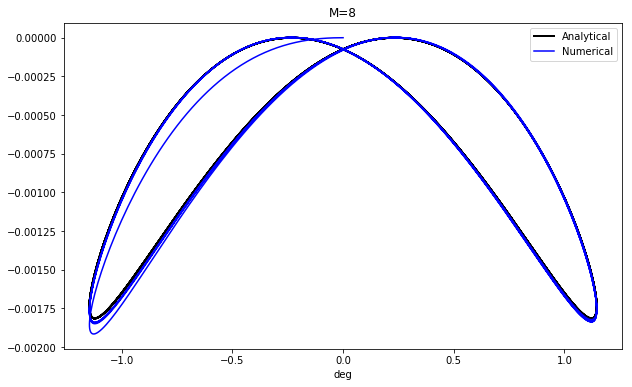

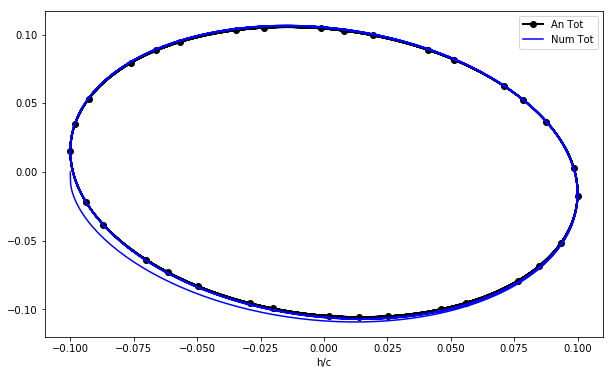

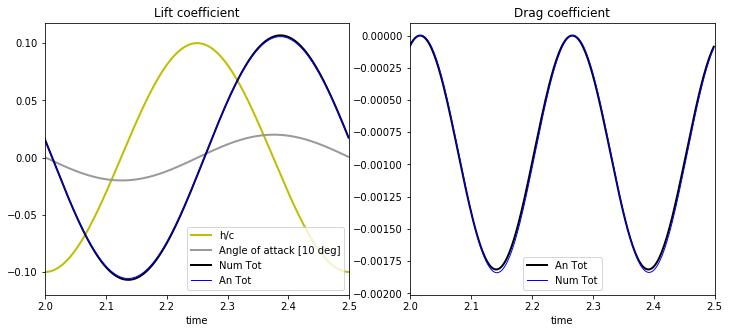

In [4]:
### random geometry
c=3.
b=0.5*c
ktarget=0.1
H=0.2*b
f0=2.#Hz
w0=2.*np.pi*f0 #rad/s
uinf=b*w0/ktarget
# Numerical solution
Ncycles=5.
WakeFact=12
T=2.*np.pi*Ncycles/w0
M=8

### solve
S=uvlm.solver(T,M,Mw=M*WakeFact,b=b,Uinf=np.array([uinf,0.]),alpha=0.,rho=1.225)
S.build_flat_plate()
S=set_dyn.plunge(S,f0=f0,H=H)
S.eps_Hall=0.003
S.solve_dyn_Gamma2d()

### post-process
hc_num=(S.THZeta[:,0,1]-H)/S.chord
aeffv_num=np.zeros((S.NT))
for tt in range(1,S.NT):
    aeffv_num[tt]=-np.arctan((S.THZeta[tt,0,1]-S.THZeta[tt-1,0,1])/S.dt/S.Uinf[0])  
THCF=S.THFaero/S.qinf/S.chord
THCFmass=S.THFaero_m/S.qinf/S.chord
THCFcirc=THCF-THCFmass        

### Analytical solution
hv_an=-H*np.cos(w0*S.time)
hc_an=hv_an/S.chord
dhv=w0*H*np.sin(w0*S.time)
aeffv_an=np.arctan(-dhv/S.Uabs)
# drag - Garrik
Cdv=an.garrick_drag_plunge(w0,H,S.chord,S.rho,uinf,S.time)
# Theodorsen
Ltot_an,Lcirc_an,Lmass_an=an.theo_lift(w0,0,H,S.chord,S.rho,S.Uinf[0],0.0)
ph_tot,ph_circ,ph_mass=np.angle(Ltot_an),np.angle(Lcirc_an),np.angle(Lmass_an)
CLtot_an=np.abs(Ltot_an)*np.cos(w0*S.time+ph_tot)/(S.chord*S.qinf)
CLcirc_an=np.abs(Lcirc_an)*np.cos(w0*S.time+ph_circ)/(S.chord*S.qinf)
CLmass_an=np.abs(Lmass_an)*np.cos(w0*S.time+ph_mass)/(S.chord*S.qinf)

### Phase plots
plt.close('all')
fig = plt.figure('Induced drag in plunge motion - Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel('deg')
ax.set_title('M=%s' %M)
ax.legend()
plt.show()
fig = plt.figure('Lift in plunge motion - Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
# analytical
ax.plot(hc_an,CLtot_an,'k',lw=2,marker='o',markevery=(.3),label=r'An Tot')
# numerical
ax.plot(hc_num,THCF[:,1],'b',label=r'Num Tot')
ax.set_xlabel('h/c')
#ax.set_ylim(-.8,.8)
ax.legend()

### Time histories
fig = plt.figure('Time histories',(12,5))
ax=fig.add_subplot(121)
ax.plot(S.time,hc_num,'y',lw=2,label='h/c')
ax.plot(S.time,aeffv_num,'0.6',lw=2,label='Angle of attack [10 deg]')
ax.plot(S.time, THCF[:,1],'k',lw=2,label='Num Tot')
ax.plot(S.time, CLtot_an,'b',lw=1,label='An Tot')
ax.set_xlabel('time')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_title('Lift coefficient')
ax.legend()
ax=fig.add_subplot(122)
ax.plot(S.time, Cdv,'k',lw=2,label='An Tot')
ax.plot(S.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_xlabel('time')
ax.set_title('Drag coefficient')
ax.legend()
plt.show()    

The match in both lift and drag is almost perfect. Note that:
- the impact of Hall's correction is not shown but is almost insignificant as the wake is "long enough";
- in the phase plot, the numerical solution is plotted using the numerically computed (backward finite differences) angle of attack. Especially at high frequency, where the time-step is relatively large, the error introduced by this approximation can be amplified in the phase plot

### Medium-high reduced frequency

Done in 135.2 sec!


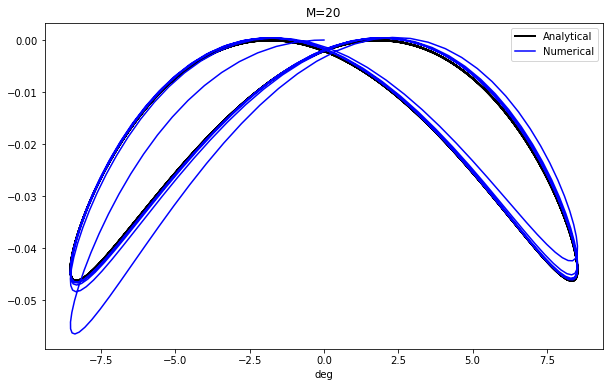

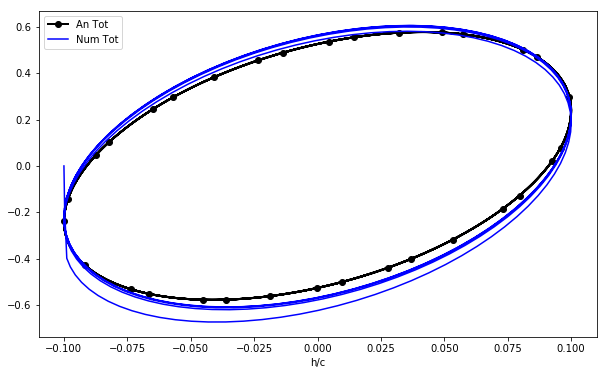

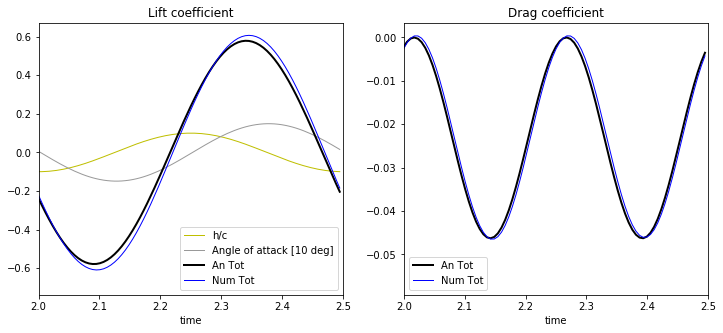

In [5]:
### random geometry
c=3.
b=0.5*c
ktarget=.75
H=0.2*b
f0=2.#Hz
w0=2.*np.pi*f0 #rad/s
uinf=b*w0/ktarget
# Numerical solution
Ncycles=5.
WakeFact=15
T=2.*np.pi*Ncycles/w0
M=20

### solve
S=uvlm.solver(T,M,Mw=M*WakeFact,b=b,Uinf=np.array([uinf,0.]),alpha=0.,rho=1.225)
S.build_flat_plate()
S=set_dyn.plunge(S,f0=f0,H=H)
S.eps_Hall=0.003
S.solve_dyn_Gamma2d()

### post-process
hc_num=(S.THZeta[:,0,1]-H)/S.chord
aeffv_num=np.zeros((S.NT))
for tt in range(1,S.NT):
    aeffv_num[tt]=-np.arctan((S.THZeta[tt,0,1]-S.THZeta[tt-1,0,1])/S.dt/S.Uinf[0])  
THCF=S.THFaero/S.qinf/S.chord
THCFmass=S.THFaero_m/S.qinf/S.chord
THCFcirc=THCF-THCFmass        

### Analytical solution
hv_an=-H*np.cos(w0*S.time)
hc_an=hv_an/S.chord
dhv=w0*H*np.sin(w0*S.time)
aeffv_an=np.arctan(-dhv/S.Uabs)
# drag - Garrik
Cdv=an.garrick_drag_plunge(w0,H,S.chord,S.rho,uinf,S.time)
# Theodorsen
Ltot_an,Lcirc_an,Lmass_an=an.theo_lift(w0,0,H,S.chord,S.rho,S.Uinf[0],0.0)
ph_tot,ph_circ,ph_mass=np.angle(Ltot_an),np.angle(Lcirc_an),np.angle(Lmass_an)
CLtot_an=np.abs(Ltot_an)*np.cos(w0*S.time+ph_tot)/(S.chord*S.qinf)
CLcirc_an=np.abs(Lcirc_an)*np.cos(w0*S.time+ph_circ)/(S.chord*S.qinf)
CLmass_an=np.abs(Lmass_an)*np.cos(w0*S.time+ph_mass)/(S.chord*S.qinf)

### Phase plots
plt.close('all')
fig = plt.figure('Induced drag in plunge motion - Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel('deg')
ax.set_title('M=%s' %M)
ax.legend()
plt.show()
fig = plt.figure('Lift in plunge motion - Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
# analytical
ax.plot(hc_an,CLtot_an,'k',lw=2,marker='o',markevery=(.3),label=r'An Tot')
# numerical
ax.plot(hc_num,THCF[:,1],'b',label=r'Num Tot')
ax.set_xlabel('h/c')
#ax.set_ylim(-.8,.8)
ax.legend()

### Time histories
fig = plt.figure('Time histories',(12,5))
ax=fig.add_subplot(121)
ax.plot(S.time,hc_num,'y',lw=1,label='h/c')
ax.plot(S.time,aeffv_num,'0.6',lw=1,label='Angle of attack [10 deg]')
ax.plot(S.time, CLtot_an,'k',lw=2,label='An Tot')
ax.plot(S.time, THCF[:,1],'b',lw=1,label='Num Tot')
ax.set_xlabel('time')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_title('Lift coefficient')
ax.legend()
ax=fig.add_subplot(122)
ax.plot(S.time, Cdv,'k',lw=2,label='An Tot')
ax.plot(S.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_xlabel('time')
ax.set_title('Drag coefficient')
ax.legend()
plt.show() 

While the induced drag matches perfectly, the lift shows some lag and a small error in the amplitude of oscillations. Note, however, that to obtain a good convergence on this problem a much higher discretisation should ideally be used. In Murua's PhD Thesis, for instance, $M=53.3 k=40$ is used. The error obtained here is, however, in line with the values reported by Murua's convergence test. A higher fidelity run has also been performed and showed a much better agreement against Theodorsen (change the values of this test and check by yourself!).

### High reduced frequency

Done in 120.3 sec!


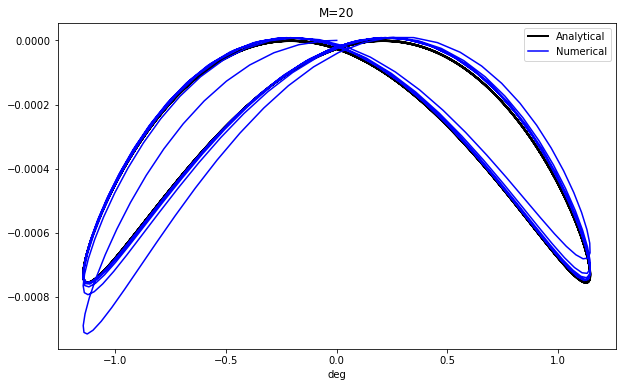

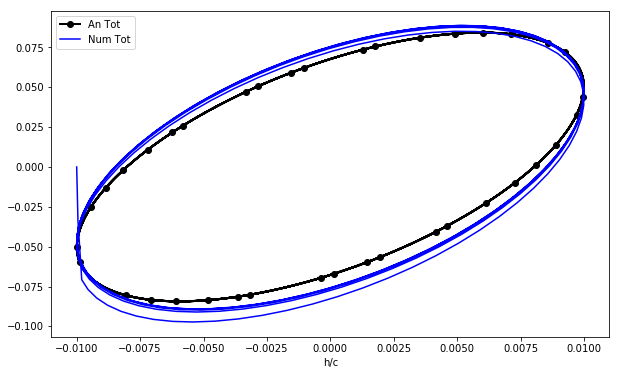

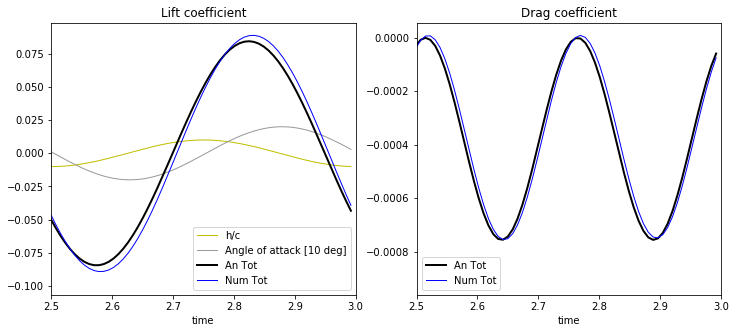

In [6]:
### random geometry
c=3.
b=0.5*c
ktarget=1.0
H=0.02*b
f0=2.#Hz
w0=2.*np.pi*f0 #rad/s
uinf=b*w0/ktarget
# Numerical solution
Ncycles=6.
WakeFact=15
T=2.*np.pi*Ncycles/w0
M=20

### solve
S=uvlm.solver(T,M,Mw=M*WakeFact,b=b,Uinf=np.array([uinf,0.]),alpha=0.,rho=1.225)
S.build_flat_plate()
S=set_dyn.plunge(S,f0=f0,H=H)
S.eps_Hall=0.003
S.solve_dyn_Gamma2d()

### post-process
hc_num=(S.THZeta[:,0,1]-H)/S.chord
aeffv_num=np.zeros((S.NT))
for tt in range(1,S.NT):
    aeffv_num[tt]=-np.arctan((S.THZeta[tt,0,1]-S.THZeta[tt-1,0,1])/S.dt/S.Uinf[0])  
THCF=S.THFaero/S.qinf/S.chord
THCFmass=S.THFaero_m/S.qinf/S.chord
THCFcirc=THCF-THCFmass        

### Analytical solution
hv_an=-H*np.cos(w0*S.time)
hc_an=hv_an/S.chord
dhv=w0*H*np.sin(w0*S.time)
aeffv_an=np.arctan(-dhv/S.Uabs)
# drag - Garrik
Cdv=an.garrick_drag_plunge(w0,H,S.chord,S.rho,uinf,S.time)
# Theodorsen
Ltot_an,Lcirc_an,Lmass_an=an.theo_lift(w0,0,H,S.chord,S.rho,S.Uinf[0],0.0)
ph_tot,ph_circ,ph_mass=np.angle(Ltot_an),np.angle(Lcirc_an),np.angle(Lmass_an)
CLtot_an=np.abs(Ltot_an)*np.cos(w0*S.time+ph_tot)/(S.chord*S.qinf)
CLcirc_an=np.abs(Lcirc_an)*np.cos(w0*S.time+ph_circ)/(S.chord*S.qinf)
CLmass_an=np.abs(Lmass_an)*np.cos(w0*S.time+ph_mass)/(S.chord*S.qinf)

### Phase plots
plt.close('all')
fig = plt.figure('Induced drag in plunge motion - Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel('deg')
ax.set_title('M=%s' %M)
ax.legend()
plt.show()
fig = plt.figure('Lift in plunge motion - Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
# analytical
ax.plot(hc_an,CLtot_an,'k',lw=2,marker='o',markevery=(.3),label=r'An Tot')
# numerical
ax.plot(hc_num,THCF[:,1],'b',label=r'Num Tot')
ax.set_xlabel('h/c')
#ax.set_ylim(-.8,.8)
ax.legend()

### Time histories
fig = plt.figure('Time histories',(12,5))
ax=fig.add_subplot(121)
ax.plot(S.time,hc_num,'y',lw=1,label='h/c')
ax.plot(S.time,aeffv_num,'0.6',lw=1,label='Angle of attack [10 deg]')
ax.plot(S.time, CLtot_an,'k',lw=2,label='An Tot')
ax.plot(S.time, THCF[:,1],'b',lw=1,label='Num Tot')
ax.set_xlabel('time')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_title('Lift coefficient')
ax.legend()
ax=fig.add_subplot(122)
ax.plot(S.time, Cdv,'k',lw=2,label='An Tot')
ax.plot(S.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_xlabel('time')
ax.set_title('Drag coefficient')
ax.legend()
plt.show() 

Even here, a small lag between analytical and numerical solution is seen. Refining the discretisation will, however, cure the problem.

### Plunge motion about non-zero angle of attack
In this case, a lowe reduced frequency is assumed.

In [2]:
### random geometry
c=3.
b=0.5*c
ktarget=0.1
H=0.01*b
f0=2.#Hz
w0=2.*np.pi*f0 #rad/s
uinf=b*w0/ktarget
alpha0=1.0*np.pi/180.
# Numerical solution
Ncycles=5.
WakeFact=12
T=2.*np.pi*Ncycles/w0
M=8

### solve
S=uvlm.solver(T,M,Mw=M*WakeFact,b=b,Uinf=np.array([uinf,0.]),alpha=alpha0,rho=1.225)
S.build_flat_plate()
S=set_dyn.plunge(S,f0=f0,H=H)
S.eps_Hall=0.003
S.solve_dyn_Gamma2d()

### post-process
hc_num=(S.THZeta[:,0,1]-H)/S.chord
aeffv_num=np.zeros((S.NT))
for tt in range(1,S.NT):
    aeffv_num[tt]=-np.arctan((S.THZeta[tt,0,1]-S.THZeta[tt-1,0,1])/S.dt/S.Uinf[0])  
THCF=S.THFaero/S.qinf/S.chord
THCFmass=S.THFaero_m/S.qinf/S.chord
THCFcirc=THCF-THCFmass        

### Analytical solution
hv_an=-H*np.cos(w0*S.time)
hc_an=hv_an/S.chord
dhv=w0*H*np.sin(w0*S.time)
aeffv_an=np.arctan(-dhv/S.Uabs)
# drag - Garrik
Cdv=an.garrick_drag_plunge(w0,H,S.chord,S.rho,uinf,S.time)
# Theodorsen
Ltot_an,Lcirc_an,Lmass_an=an.theo_lift(w0,0,H,S.chord,S.rho,S.Uinf[0],0.0)
ph_tot,ph_circ,ph_mass=np.angle(Ltot_an),np.angle(Lcirc_an),np.angle(Lmass_an)
# static lift
L0=2.0*np.pi*alpha0*S.chord*S.qinf

CLtot_an=(L0+np.abs(Ltot_an)*np.cos(w0*S.time+ph_tot))/(S.chord*S.qinf)
CLcirc_an=np.abs(Lcirc_an)*np.cos(w0*S.time+ph_circ)/(S.chord*S.qinf)
CLmass_an=np.abs(Lmass_an)*np.cos(w0*S.time+ph_mass)/(S.chord*S.qinf)

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


Done in 67.3 sec!


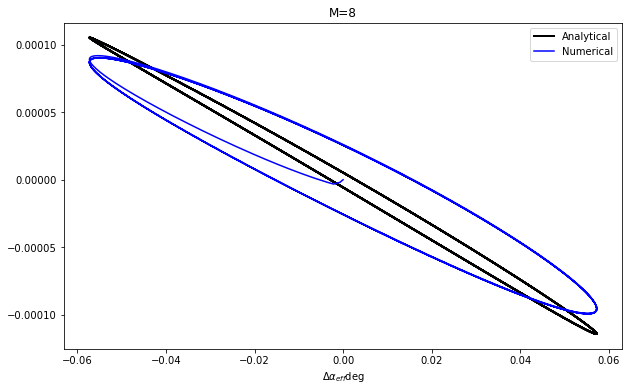

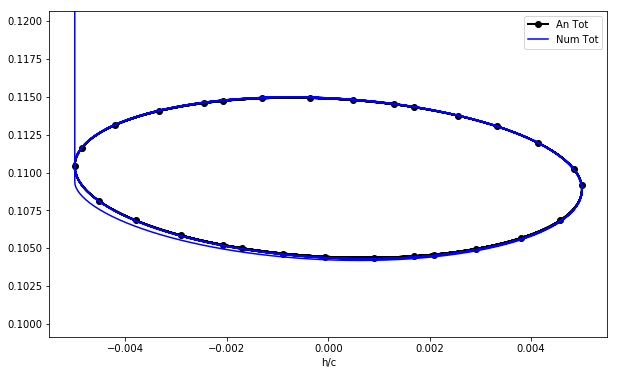

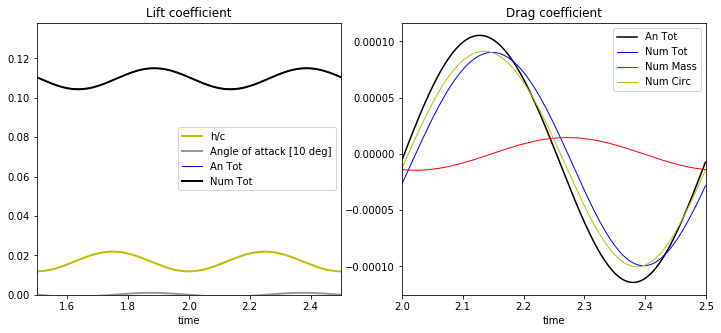

In [13]:
### augment analytically computed drag with circulatory and mass terms
CL0=2.*np.pi*alpha0
CdvCirc=-CL0*aeffv_an
ddhv=w0**2 *H*np.cos(w0*S.time)
CdvMass=-1.225*np.pi*b**2*ddhv*alpha0 /S.qinf/S.chord

### Phase plots
plt.close('all')
fig = plt.figure('Induced drag in plunge motion - Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv+CdvMass+CdvCirc,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel(r'$\Delta \alpha_{eff}$deg')
ax.set_title('M=%s' %M)
ax.legend()
plt.show()
fig = plt.figure('Lift in plunge motion - Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
# analytical
ax.plot(hc_an,CLtot_an,'k',lw=2,marker='o',markevery=(.3),label=r'An Tot')
# numerical
ax.plot(hc_num-hc_num[0]-H/c,THCF[:,1],'b',label=r'Num Tot')
ax.set_xlabel('h/c')
ax.set_ylim(0.95*np.min(CLtot_an),1.05*np.max(CLtot_an))
ax.legend()

### Time histories
fig = plt.figure('Time histories',(12,5))
ax=fig.add_subplot(121)
ax.plot(S.time,hc_num,'y',lw=2,label='h/c')
ax.plot(S.time,aeffv_num,'0.6',lw=2,label='Angle of attack [10 deg]')
ax.plot(S.time, CLtot_an,'b',lw=1,label='An Tot')
ax.plot(S.time, THCF[:,1],'k',lw=2,label='Num Tot')
#ax.plot(S.time,THCFmass[:,1],'r',label=r'Numerical Mass')
#ax.plot(S.time,CLmass_an,'y',label=r'Analytical Mass')
ax.set_xlabel('time')
ax.set_xlim((1.-2./Ncycles)*T, T)
ax.set_ylim(0.0,1.2*np.max(CLtot_an))

ax.set_title('Lift coefficient')
ax.legend()
ax=fig.add_subplot(122)
ax.plot(S.time, Cdv+CdvMass+CdvCirc,'k',label='An Tot')
ax.plot(S.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax.plot(S.time, THCFmass[:,0],'r',lw=1,label='Num Mass')
ax.plot(S.time, THCFcirc[:,0],'y',lw=1,label='Num Circ')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_xlabel('time')
ax.set_title('Drag coefficient')
ax.legend()
plt.show()  

The accuracy in lift prediction is very good, though the numerical solution shows a high force being generated at the beginning of the simulation. The trend in drag prediction, as well as the approximation used to derive the analytical trend, are explained in valid_lin_dynamic_nonzero.

## Impulsive start

This test shows the solution to Wagner's problem.

In [7]:
### random geometry
M=6
WakeFact=20
c=3.
b=0.5*c
uinf=20.0
aeff=1.0*np.pi/180.
T=5.0

###### Numerical solution - Hall's correction
S=uvlm.solver(T=T,M=M,Mw=M*WakeFact,b=b,Uinf=np.array([uinf,0.]),
              alpha=aeff)
S.build_flat_plate()
S._imp_start=True
S.eps_Hall=0.003
S._update_AIC=True
S.solve_dyn_Gamma2d()

###### Numerical solution - no Hall's correction
S2=uvlm.solver(T=T,M=M,Mw=M*WakeFact,b=b,Uinf=np.array([uinf,0.]),
              alpha=aeff)
S2.build_flat_plate()
S2._imp_start=True
S2.eps_Hall=1.0
S2._update_AIC=True
S2.solve_dyn_Gamma2d()

##### Analytical solution
CLv_an=an.wagner_imp_start(aeff,uinf,c,S.time)

##### Post-process numerical solution - Hall's correction
THCF=S.THFaero/S.qinf/S.chord
# Mass and circulatory contribution
THCFmass=S.THFaero_m/S.qinf/S.chord
THCFcirc=THCF-THCFmass

##### Post-process numerical solution - no Hall's correction
THCF2=S2.THFaero/S2.qinf/S2.chord
# Mass and circulatory contribution
THCFmass2=S2.THFaero_m/S2.qinf/S2.chord
THCFcirc2=THCF2-THCFmass2

Done in 7.4 sec!
Done in 7.6 sec!


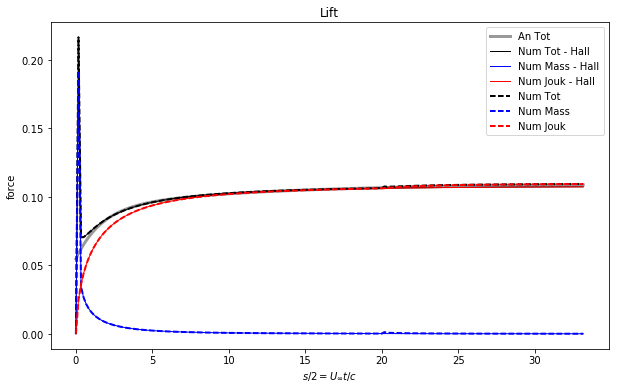

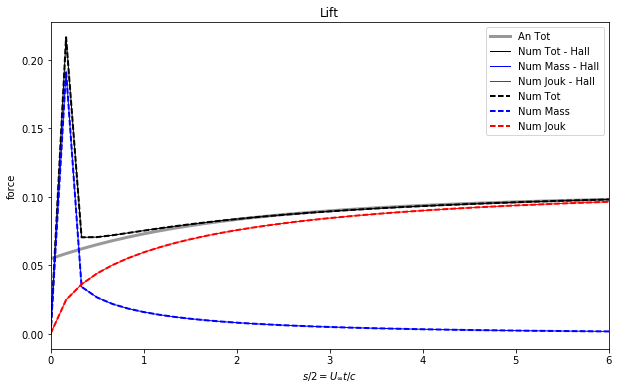

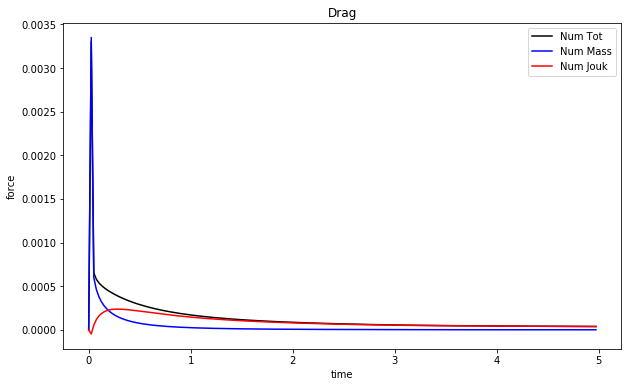

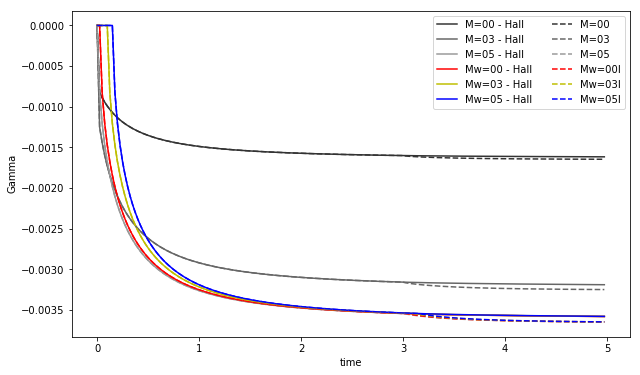

In [8]:
plt.close('all')
# non-dimensional time
sv=2.0*S.Uabs*S.time/S.chord
fig = plt.figure('Lift coefficient',(10,6))
ax=fig.add_subplot(111)
# Wagner
ax.plot(0.5*sv, CLv_an,'0.6',lw=3,label='An Tot')
# numerical
ax.plot(0.5*sv, THCF[:,1],'k',lw=1,label='Num Tot - Hall')
ax.plot(0.5*sv, THCFmass[:,1],'b',lw=1,label='Num Mass - Hall')
ax.plot(0.5*sv, THCFcirc[:,1],'r',lw=1,label='Num Jouk - Hall')
# numerical
ax.plot(0.5*sv, THCF2[:,1],'k--',lw=2,label='Num Tot')
ax.plot(0.5*sv, THCFmass2[:,1],'b--',lw=2,label='Num Mass')
ax.plot(0.5*sv, THCFcirc2[:,1],'r--',lw=2,label='Num Jouk')
ax.set_xlabel(r'$s/2=U_\infty t/c$')
ax.set_ylabel('force')
ax.set_title('Lift')
ax.legend()

fig2 = plt.figure('Lift coefficient - zoom',(10,6))
ax=fig2.add_subplot(111)
# Wagner
ax.plot(0.5*sv, CLv_an,'0.6',lw=3,label='An Tot')
# numerical
ax.plot(0.5*sv, THCF[:,1],'k',lw=1,label='Num Tot - Hall')
ax.plot(0.5*sv, THCFmass[:,1],'b',lw=1,label='Num Mass - Hall')
ax.plot(0.5*sv, THCFcirc[:,1],'r',lw=1,label='Num Jouk - Hall')
# numerical
ax.plot(0.5*sv, THCF2[:,1],'k--',lw=2,label='Num Tot')
ax.plot(0.5*sv, THCFmass2[:,1],'b--',lw=2,label='Num Mass')
ax.plot(0.5*sv, THCFcirc2[:,1],'r--',lw=2,label='Num Jouk')
ax.set_xlabel(r'$s/2=U_\infty t/c$')
ax.set_ylabel('force')
ax.set_title('Lift')
ax.legend()
ax.set_xlim(0.,6.)

fig = plt.figure('Drag coefficient',(10,6))
ax=fig.add_subplot(111)
ax.plot(S.time, THCF[:,0],'k',label='Num Tot')
ax.plot(S.time, THCFmass[:,0],'b',label='Num Mass')
ax.plot(S.time, THCFcirc[:,0],'r',label='Num Jouk')
ax.set_xlabel('time')
ax.set_ylabel('force')
ax.set_title('Drag')
ax.legend()

# Tiome histories of circulation
fig = plt.figure('Vortex rings circulation time history',(10,6))
ax=fig.add_subplot(111)
clist=['0.2','0.4','0.6']
Mlist=[0,int(S.M/2),S.M-1]
for kk in range(len(Mlist)):
    mm=Mlist[kk]
    ax.plot(S.time,S.THGamma[:,mm],color=clist[kk],label='M=%.2d - Hall'%(mm))
clist=['r','y','b']
MWlist=[0,int(S.Mw/2),S.Mw-1]
for kk in range(len(MWlist)):
    mm=Mlist[kk]
    ax.plot(S.time,S.THGammaW[:,mm],color=clist[kk],label='Mw=%.2d - Hall'%(mm))
clist=['0.2','0.4','0.6']
Mlist=[0,int(S.M/2),S.M-1]
for kk in range(len(Mlist)):
    mm=Mlist[kk]
    ax.plot(S2.time,S2.THGamma[:,mm],color=clist[kk],linestyle='--',
                                                                   label='M=%.2d'%(mm))
clist=['r','y','b']
MWlist=[0,int(S.Mw/2),S.Mw-1]
for kk in range(len(MWlist)):
    mm=Mlist[kk]
    ax.plot(S2.time,S2.THGammaW[:,mm],color=clist[kk],linestyle='--',
                                                                 label='Mw=%.2dl'%(mm))

ax.set_xlabel('time')
ax.set_ylabel('Gamma')
ax.legend(ncol=2)
plt.show()

It can be observed that:
- Hall's correction has basically no impact on the force time histories, though it can be observed in the circulation time history as the disturbances from the aerofoil arrive at the end of the wake ($s \approx 3$)
- At $t=0$ the aerodynamic force jumps to a very high value: this is compatible with the backward first order approximation of the time derivative in the code - the analytical solution assumes an infinite increase of the aerodynamic force at $t=0$. Also note that the jump in aerodynamic force is linked to the unsteady (added mass) term.
- Hall's correction reduces the accuracy at the steady state / slows-down the convergence to the steady lift.

## Sinusoidal gust
Finally, we consider the response to a sinusoidal gust (Sears' solution). The impact of high/low frequencies/wavelength is not studied here. As in the previous cases, the aerofoil is set at a zero angle of attack.

In [40]:
# random geometry
c=3.
b=0.5*c

# gust profile
w0=0.01
uinf=2.0
L=10.0*c   # <--- gust wakelength

# discretisation
WakeFact=18
Ncycles=10 # number of "cycles"
Mfact=2
if c>L: M=np.ceil(4*Mfact*c/L)
else: M=Mfact*4

# Numerical solution
S=uvlm.solver(Ncycles*L/uinf,M,Mw=M*WakeFact,b=b,Uinf=np.array([uinf,0.]),
                                                         alpha=0.*np.pi/180.,rho=1.225)
S.build_flat_plate()
S=set_gust.sin(S,w0,L,ImpStart=False)
S.eps_Hall=0.003
S.solve_dyn_Gamma2d()
THCF=S.THFaero/S.qinf/S.chord

# Analytical solution
CLv = an.sears_lift_sin_gust(w0,L,uinf,c,S.time)

../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


Done in 47.6 sec!


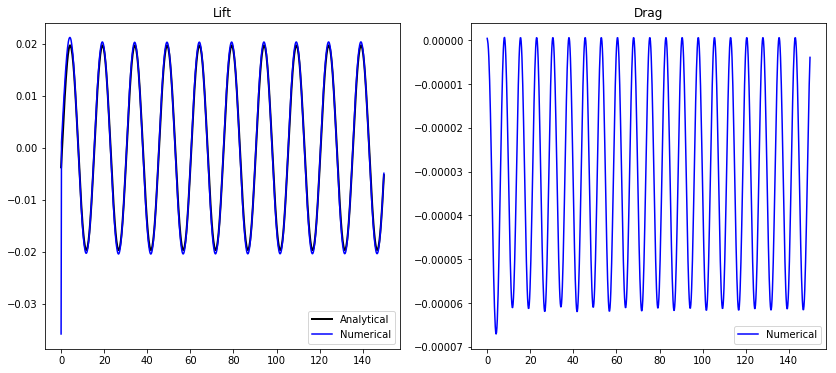

In [42]:
fig = plt.figure('Aerodynamic force coefficients',(14,6))
ax=fig.add_subplot(121)
ax.set_title(r'Lift')
ax.plot(S.time,CLv,'k',lw=2,label=r"Analytical")
ax.plot(S.time,THCF[:,1],'b',label=r'Numerical')
ax.legend()

ax2=fig.add_subplot(122)
ax2.set_title(r'Drag')
ax2.plot(S.time,THCF[:,0],'b',label=r'Numerical')
ax2.legend()


plt.show()

The lift response phase and amplitude matches very well. Note that a small drag force is also predicted. The circulatory contribution of the aerodynamic force is, in fact, always perpendicular to the instantaneous flow direction. As this tilts due to the gust component of the velocity, a drag force is generated. In this case the force is only propulsive: when the gust speed is upward, the lift is positive and tilted forward. As the gust speed moves down, the lift is negative and, again, pointing forward.